# Section 4.2.3. GAN

In [10]:
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import *

torch.manual_seed(0)

In [11]:
# -------------------------------
# Define the Generator and Discriminator
# -------------------------------
class Generator(nn.Module):
    def __init__(self, z_dim, input_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen_fc = nn.Sequential(
            nn.Linear(z_dim, 128 * 8 * 8),
            nn.ReLU(True)
        )
        self.gen_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, input_dim, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.gen_fc(x)
        x = x.view(x.size(0), 128, 8, 8)
        x = self.gen_conv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.disc_conv = nn.Sequential(
            nn.Conv2d(input_dim, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.disc_fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.disc_conv(x)
        x = x.view(x.size(0), -1)
        x = self.disc_fc(x)
        return x

## 1. Training Stage

In [12]:
# -------------------------------
# Training and loss calculation
# -------------------------------
def train_gan(generator, discriminator, data_loader, optim_gen, optim_disc, criterion, num_epochs, device, z_dim, real_label, fake_label):
    generator.train()
    discriminator.train()
    total_samples = len(data_loader.dataset)

    for epoch in range(num_epochs):
        running_loss_D = 0.0
        running_loss_G = 0.0
        for data in data_loader:
            # --- Discriminator ---
            discriminator.zero_grad()
            real_data = data.to(device)
            batch_size = real_data.size(0)
            label = torch.full((batch_size,), real_label, device=device).float()

            output = discriminator(real_data).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()

            noise = torch.randn(batch_size, z_dim, device=device)
            fake = generator(noise)
            label.fill_(fake_label)
            output = discriminator(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optim_disc.step()
            running_loss_D += errD.item() * batch_size

            # --- Generator ---
            generator.zero_grad()
            label.fill_(real_label) 
            output = discriminator(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            optim_gen.step()
            running_loss_G += errG.item() * batch_size

        avg_loss_D = running_loss_D / total_samples
        avg_loss_G = running_loss_G / total_samples
        print(f'Epoch [{epoch+1:02}/{num_epochs}] Loss_D: {avg_loss_D:>6.4f} Loss_G: {avg_loss_G:>6.4f}')

    return generator, discriminator

![alt text](img/GAN_edit.png "Title")

The learning process is guided by a value function $V(\phi, \theta)$, defined as follows:

- $V(\phi, \theta) = \mathbb{E}_{\mathbf{x} \sim p_{data}(\mathbf{x})}[\log D_{\phi}(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})}[\log(1 - D_{\phi}(G_{\theta}(\mathbf{z})))]$

The learning process involves simultaneously optimizing the parameters of both $G$ and $D$, specifically $\theta$ and $\phi$, through gradient-based methods as shown below. This process alternates between the following two steps:
 

- $ Goal: \phi^{*},\theta^{*} = \min_{G_{\theta}} \max_{G_{\phi}} V(\phi, \theta)$

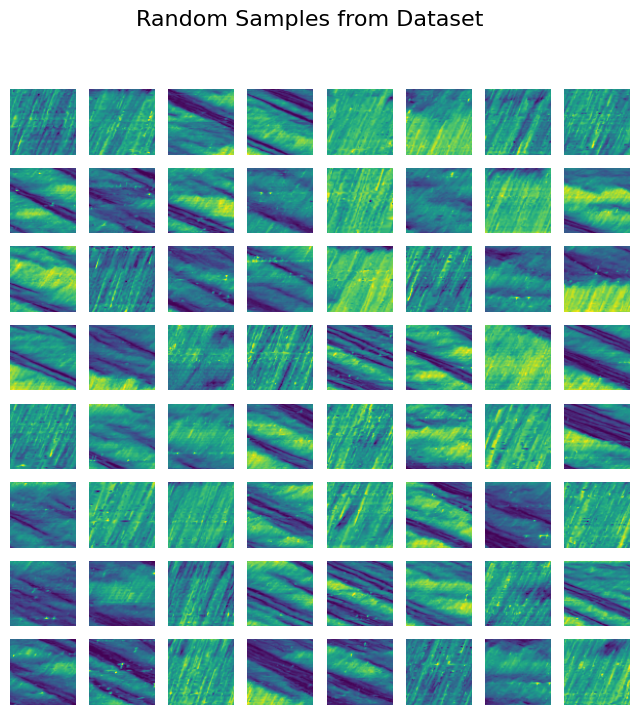

In [13]:
data_path = '../dataset/i24_normalized.pt'
batch_size = 250
z_dim = 64
lr = 0.0002
beta1 = 0.5
num_epochs = 50
real_label = 1.0
fake_label = 0.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset, data_loader = load_and_preprocess_data(data_path, batch_size)

input_dim = dataset.shape[1] # dataset.shape: [40000, 1, 64, 64] → input_dim = 1

generator = Generator(z_dim, input_dim).to(device)
discriminator = Discriminator(input_dim).to(device)

optim_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()

In [14]:
generator, discriminator = train_gan(generator, discriminator, data_loader, optim_gen, optim_disc,
                                        criterion, num_epochs, device, z_dim, real_label, fake_label)

os.makedirs("models", exist_ok=True)
torch.save(generator.state_dict(), 'models/generator.pth')
torch.save(discriminator.state_dict(), 'models/discriminator.pth')
print("Generator and Discriminator models saved.")

Epoch [01/50] Loss_D: 0.0917 Loss_G: 5.6866
Epoch [02/50] Loss_D: 0.0128 Loss_G: 5.9911
Epoch [03/50] Loss_D: 0.6005 Loss_G: 3.0655
Epoch [04/50] Loss_D: 0.7368 Loss_G: 2.0422
Epoch [05/50] Loss_D: 0.5204 Loss_G: 2.5715
Epoch [06/50] Loss_D: 0.5737 Loss_G: 3.0471
Epoch [07/50] Loss_D: 0.4699 Loss_G: 3.5574
Epoch [08/50] Loss_D: 0.3616 Loss_G: 4.6474
Epoch [09/50] Loss_D: 0.5950 Loss_G: 3.2765
Epoch [10/50] Loss_D: 0.5646 Loss_G: 2.8546
Epoch [11/50] Loss_D: 0.7346 Loss_G: 2.3778
Epoch [12/50] Loss_D: 0.6063 Loss_G: 2.8870
Epoch [13/50] Loss_D: 0.6227 Loss_G: 3.2483
Epoch [14/50] Loss_D: 0.6832 Loss_G: 2.8946
Epoch [15/50] Loss_D: 0.7052 Loss_G: 2.6625
Epoch [16/50] Loss_D: 0.7252 Loss_G: 2.4410
Epoch [17/50] Loss_D: 0.6518 Loss_G: 2.4983
Epoch [18/50] Loss_D: 0.7058 Loss_G: 2.1677
Epoch [19/50] Loss_D: 0.6627 Loss_G: 2.2793
Epoch [20/50] Loss_D: 0.7074 Loss_G: 1.7254
Epoch [21/50] Loss_D: 0.6641 Loss_G: 1.7830
Epoch [22/50] Loss_D: 0.7380 Loss_G: 1.8264
Epoch [23/50] Loss_D: 0.7008 Los

## 2. Testing Stage

In [15]:
def visualize_generated_samples(generator, z_dim, device, nrows=8, ncols=8, save_path="img/GAN_result.png"):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(nrows * ncols, z_dim, device=device)
        samples = generator(z).cpu().numpy()

    fig, ax = plt.subplots(nrows, ncols, figsize=(8, 8))
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            ax[i, j].imshow(samples[idx][0, :, :], origin="lower", cmap="viridis")
            ax[i, j].axis("off")
    plt.suptitle("Generated Samples", fontsize=16)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=500)
    plt.show()
    plt.close()

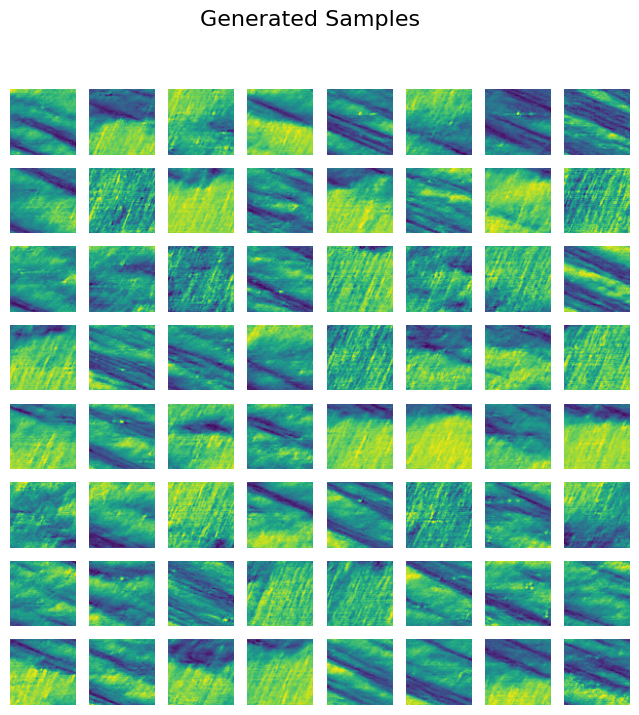

In [16]:
# Can use CPU in the inference, but highly recommended to use GPU
# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(z_dim, input_dim).to(device)
generator.load_state_dict(torch.load('models/generator.pth', map_location=device))
generator.eval()

os.makedirs("img", exist_ok=True)
visualize_generated_samples(generator, z_dim, device, nrows=8, ncols=8, save_path="img/GAN_result.png")